# scGen for multi-omic integration

In [398]:
import scgen
import anndata
import numpy as np
import scanpy as sc
import pandas as pd
import tensorflow as tf
import sparse

Using PBMC data used in LIGER tutorial (downloaded from [here](https://umich.app.box.com/s/5hkhpou4inrulo570yhc38ay8g3ont5b))

In [333]:
train = sc.read_10x_h5('/home/jovyan/my_data/10X_data/intPBMC_10x.hdf5')
atac_clust = pd.read_csv('/home/jovyan/my_data/10X_data/atac_cluster_assignments.csv', )
rna_clust = pd.read_csv('/home/jovyan/my_data/10X_data/rna_cluster_assignments.csv')
        
rna_clust.columns = ['cell_id', 'cell_type']
atac_clust.columns = ['cell_id', 'cell_type']

### Add cluster and batch information to `train.obs`

In [334]:
train.obs.index.name = 'cell_id'
# train.obs.reset_index(inplace=True)
# # train.obs=pd.merge(train.obs, rna_clust, how="left", sort=False).set_index('cell_id')


In [335]:
train_clust = pd.concat([rna_clust, atac_clust])
train_clust = train_clust.assign(batch= [np.where(x[:8]=="pbmc.rna", 0, 1) for x in train_clust['cell_id']])


In [336]:
train.obs = pd.merge(train.obs, train_clust, how="outer", left_index=True, right_on="cell_id").set_index('cell_id')

In [337]:
train.obs.reset_index(inplace=True)

In [297]:
# train.obs.reset_index(inplace=True)
# train.obs = train.obs.reset_index(inplace=True)

,index,cell_id,cell_type,batch
0,0,pbmc.rna_AAACCCAAGCGCCCAT,CD4 Memory,RNA
1,1,pbmc.rna_AAACCCAAGGTTCCGC,NaN,RNA
2,2,pbmc.rna_AAACCCACAGAGTTGG,CD14+ Monocytes,RNA
3,3,pbmc.rna_AAACCCACAGGTATGG,NK dim,RNA
4,4,pbmc.rna_AAACCCACATAGTCAC,pre-B cell,RNA
...,...,...,...,...
20492,20492,TTTGTGTTCATGCTTT-1,NaN,ATAC
20493,20493,TTTGTGTTCCGAGAGA-1,Monocyte,ATAC
20494,20494,TTTGTGTTCGAAGCCC-1,NaN,ATAC
20495,20495,TTTGTGTTCTACTTTG-1,T cell,ATAC


In [338]:
train.obs = train.obs.assign(batch= [np.where(x[:8]=="pbmc.rna", 0, 1) for x in train.obs['cell_id']]).set_index("cell_id")

{'B cell', 'DC', 'Monocyte', 'NK cell', 'T cell', nan}

### Normalize and scale data

In [339]:
train_raw = train.copy()
sc.pp.normalize_per_cell(train)


In [340]:
sc.pp.log1p(train)

### Identify highly variable genes
I have already done this (LIGER preprocessing), based only on HVG in the RNA

### Map manifold


In [310]:
sc.tl.pca(train, svd_solver = 'arpack', random_state = 1786)
sc.pp.neighbors(train, random_state = 1712)
sc.tl.umap(train, min_dist = 0.3, spread = 1, random_state = 1712)

/home/jovyan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


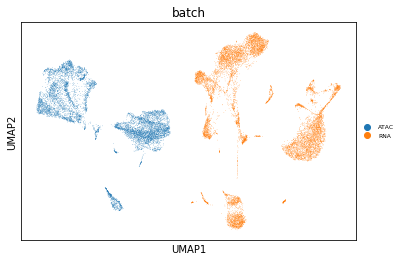

In [313]:
sc.pl.umap(train, color = ['batch'], size = 1, legend_fontsize = 6, color_map = 'RdPu')

### Run scgen

In [341]:
train_scgen = train.copy()

In [382]:
train_scgen = train_scgen[train_scgen.obs.cell_type.isnull()==False]

In [383]:
tf.reset_default_graph()
network = scgen.VAEArith(x_dimension = train_scgen.shape[1], model_path = "/home/jovyan/10X_data/scgen_PBMC")

In [384]:
network.train(train_data = train_scgen, n_epochs = 10)

In [385]:
corrected_adata = scgen.batch_removal(network, train_scgen)

TypeError: concatenate() missing 1 required positional argument: 'self'

In [406]:
adata=train_scgen
cell_label_key="cell_type"
batch_key="batch"
# if sparse.issparse(adata.X):
#     latent_all = network.to_latent(adata.X.A)
# else:
latent_all = network.to_latent(adata.X.A)

In [407]:
adata_latent = anndata.AnnData(latent_all)
adata_latent.obs = adata.obs.copy(deep=True)
unique_cell_types = np.unique(adata_latent.obs[cell_label_key])
shared_ct = []


In [415]:
set(train_scgen.obs[train_scgen.obs.batch==0].cell_type)

{'B cell progenitor',
 'CD14+ Monocytes',
 'CD16+ Monocytes',
 'CD4 Memory',
 'CD4 Naive',
 'CD8 Naive',
 'CD8 effector',
 'Dendritic cell',
 'Double negative T cell',
 'Megakaryocytes',
 'NK bright',
 'NK dim',
 'pDC',
 'pre-B cell'}

In [417]:
set(train_scgen.obs[train_scgen.obs.batch==1].cell_type)

{'B cell', 'DC', 'Monocyte', 'NK cell', 'T cell'}

In [393]:

    not_shared_ct = []
    for cell_type in unique_cell_types:
        temp_cell = adata_latent[adata_latent.obs[cell_label_key] == cell_type]
        if len(np.unique(temp_cell.obs[batch_key])) < 2:
            cell_type_ann = adata_latent[adata_latent.obs[cell_label_key] == cell_type]
            not_shared_ct.append(cell_type_ann)
            continue
        temp_cell = adata_latent[adata_latent.obs[cell_label_key] == cell_type]
        batch_list = {}
        batch_ind = {}
        max_batch = 0
        max_batch_ind = ""
        batches = np.unique(temp_cell.obs[batch_key])
        for i in batches:
            temp = temp_cell[temp_cell.obs[batch_key] == i]
            temp_ind = temp_cell.obs[batch_key] == i
            if max_batch < len(temp):
                max_batch = len(temp)
                max_batch_ind = i
            batch_list[i] = temp
            batch_ind[i] = temp_ind
        max_batch_ann = batch_list[max_batch_ind]
        for study in batch_list:
            delta = np.average(max_batch_ann.X, axis=0) - np.average(batch_list[study].X, axis=0)
            batch_list[study].X = delta + batch_list[study].X
            temp_cell[batch_ind[study]].X = batch_list[study].X
        shared_ct.append(temp_cell)
    all_shared_ann = anndata.AnnData.concatenate(*shared_ct, batch_key="concat_batch")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

# You need to uniform cell type annotation

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/jovyan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
... storing 'batch' as categorical
... storing 'cell_type' as categorical
... storing 'concat_batch' as categorical


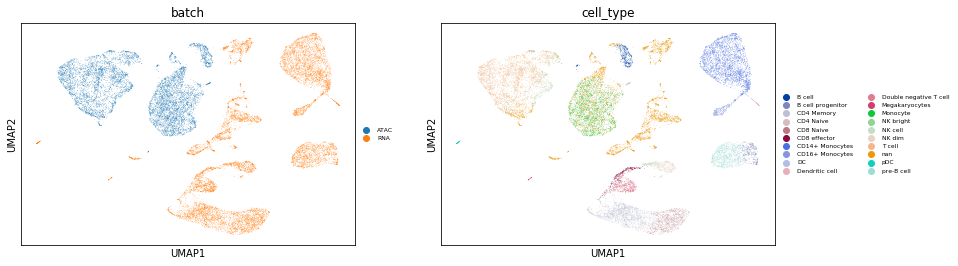

In [323]:
sc.pp.neighbors(corrected_adata, random_state = 1786)
sc.tl.umap(corrected_adata, min_dist = 0.3, spread = 1, random_state = 1786)
sc.pl.umap(corrected_adata, color = ['batch', 'cell_type'], size = 1, legend_fontsize = 6, color_map = 'RdPu')

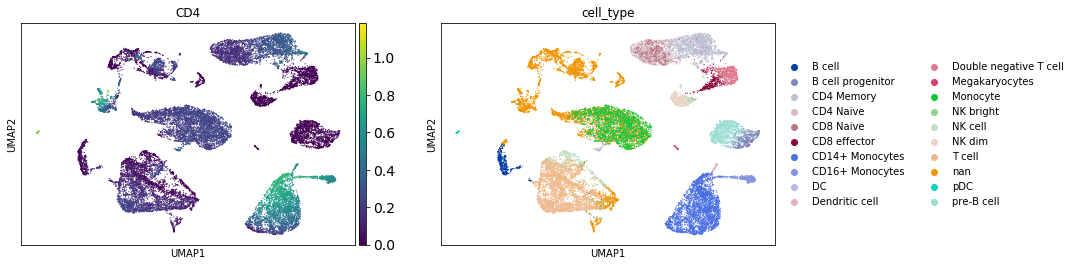

In [268]:
sc.pl.umap(corrected_adata, color=[ "CD4", "cell_type"])

In [272]:
train_scgen.shape

(20497, 19833)

,batch,cell_type,concat_batch,index,n_counts
pbmc.rna_AAACCCAAGCGCCCAT,RNA,nan,nan,1,17680.0
pbmc.rna_AAACCCAAGGTTCCGC,RNA,nan,nan,7,6272.0
pbmc.rna_AAACCCACAGAGTTGG,RNA,nan,nan,8,4613.0
pbmc.rna_AAACCCACAGGTATGG,RNA,nan,nan,14,4988.0
pbmc.rna_AAACCCACATAGTCAC,RNA,nan,nan,15,4047.0
...,...,...,...,...,...
TTTGTGTTCATGCTTT-1,RNA,pre-B cell,18,11706,4473.0
TTTGTGTTCCGAGAGA-1,RNA,pre-B cell,18,11708,4476.0
TTTGTGTTCGAAGCCC-1,RNA,pre-B cell,18,11719,9185.0
TTTGTGTTCTACTTTG-1,RNA,pre-B cell,18,11738,3380.0
